In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import yfinance as yf
from scipy import stats

from sklearn.datasets import fetch_california_housing
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.robust import norms




## Addressing Kurtosis and Heteroscedasticity
### Best Practices Handbook 

 ## 1. Kurtosis Analysis

 ### Definition
 Kurtosis measures the "tailedness" of a probability distribution relative to a normal distribution. Given a continuous random variable $X$ under a probability distribution, the excess kurtosis of that distribution is calculated as:

 $$
 \text{Excess Kurtosis} = \frac{E((X-E(X))^4)}{E((X-E(X))^2)} - 3
 $$
 where the -3 adjustment makes normal distribution kurtosis = 0 (DeCarlo, 1997).

 ### Description
 - Positive excess kurtosis indicates heavy tails (more outliers than normal distribution). The distribution is said leptokurtic
 - negative suggests light tails. The distribution is said platykurtic.

 ### Demonstration
 For numerical demonstration, we'll simulate three distributions with different kurtosis properties:
 - Normal kurtosis: normal distribution,
 - Positive excess kurtosis: t-Student distribution,
 - Negative excess kurtosis: uniform distribution.


In [43]:
np.random.seed(90)
normal_data = np.random.normal(0, 1, 1000)
student_data = np.random.standard_t(df=3, size=1000)  # Leptokurtic
uniform_data = np.random.uniform(-np.sqrt(3), np.sqrt(3), 1000)  # Platykurtic

# Calculate kurtosis
kurtosis = {
    "Normal": stats.kurtosis(normal_data),
    "Student": stats.kurtosis(student_data),
    "Uniform": stats.kurtosis(uniform_data)
}

print("Excess Kurtosis Values:")
for dist, k in kurtosis.items():
    print(f"{dist}: {k:.2f}")

Excess Kurtosis Values:
Normal: -0.08
Student: 9.01
Uniform: -1.21



 ### Diagram
 Visual comparison of the distributions:
- **Leptokurtic distributions** (such as the Student's t-distribution) have heavier tails than the standard normal distribution, meaning they exhibit more extreme values.
- **Platykurtic distributions** (such as the uniform distribution) have thinner tails and lie below the standard normal density curve.

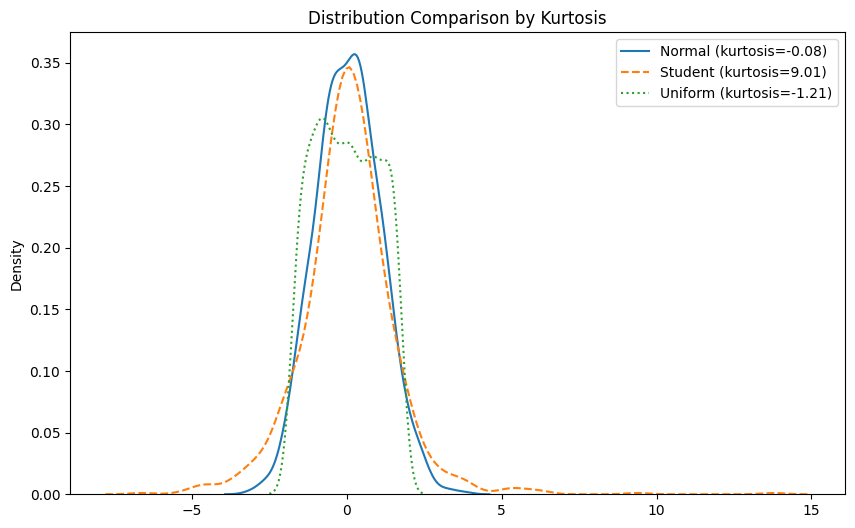

In [44]:
plt.figure(figsize=(10, 6))
sns.kdeplot(normal_data, label=f"Normal (kurtosis={kurtosis['Normal']:.2f})")
sns.kdeplot(student_data, label=f"Student (kurtosis={kurtosis['Student']:.2f})", linestyle="--")
sns.kdeplot(uniform_data, label=f"Uniform (kurtosis={kurtosis['Uniform']:.2f})", linestyle=":")
plt.title("Distribution Comparison by Kurtosis")
plt.legend()
plt.show()

 ### Diagnosis
 How to detect problematic kurtosis:
To formally detect whether the sample data has excess kurtosis, we perform a **hypothesis test**:

#### Hypothesis Test for Excess Kurtosis:
- **Null Hypothesis ($H_0$)**: The sample has **no Excess kurtosis** (excess kurtosis = 0).
- **Alternative Hypothesis ($H_1$)**: The sample has **non-normal kurtosis** (excess kurtosis $\neq$ 0).

Under the **null hypothesis**, the distribution of the test statistic for excess kurtosis should follow an **asymptotic normal distribution** for large sample sizes (Westfall, 1993).

The **kurtosistest** in the Python **SciPy** library performs this test by calculating the **excess kurtosis** and its corresponding p-value.

#### Test Statistic:
The test statistic is computed under the null hypothesis as:

$$
\text{Test Statistic} = \frac{ \hat{K}}{ \sigma_{\hat{K}} }
$$

where:
- $\hat{K}$ is the **sample excess kurtosis**,
- $\sigma_{\hat{K}}$ is the **standard error** of the sample kurtosis.

#### Decision Rule:
- If the **p-value** is **less than the significance level** (typically $ \alpha = 0.05 $), we reject the null hypothesis, indicating **significant excess kurtosis**.
- If the **p-value** is **greater than** the significance level, we fail to reject the null hypothesis, suggesting that the sample is consistent with normal kurtosis.


Below is the Python implementation using `scipy.stats.kurtosistest` to perform the test for excess kurtosis on a given data sample.


In [45]:
def diagnose_kurtosis(data, alpha=0.05):
    k = stats.kurtosis(data)
    stat, p = stats.kurtosistest(data)
    
    print(f"Excess Kurtosis: {k:.2f}")
    print(f"Kurtosis Test p-value: {p:.4f}")
    
    if p < alpha:
        print("Significant non-normal kurtosis detected (p < 0.05)")
    else:
        print("No significant kurtosis detected")
    
    if k > 1:
        print("Warning: Heavy tails (leptokurtic)")
    elif k < -1:
        print("Warning: Light tails (platykurtic)")


In [46]:
# Appliying the test on the samples distribution generated above

diagnose_kurtosis(normal_data) # normal distribution

Excess Kurtosis: -0.08
Kurtosis Test p-value: 0.6779
No significant kurtosis detected


In [47]:
diagnose_kurtosis(student_data) # student distribution

Excess Kurtosis: 9.01
Kurtosis Test p-value: 0.0000
Significant non-normal kurtosis detected (p < 0.05)


In [48]:
diagnose_kurtosis(uniform_data) # Uniform distribution

Excess Kurtosis: -1.21
Kurtosis Test p-value: 0.0000
Significant non-normal kurtosis detected (p < 0.05)


### Results from Hypothesis Test:
1. **Normal Distribution Sample**:
   - The test for excess kurtosis on a sample generated from a **normal distribution** resulted in a **p-value of 0.67**. This is **greater than 0.05**, meaning that we **fail to reject the null hypothesis**. Therefore, the sample does **not exhibit excess kurtosis**, and it is consistent with a normal distribution.

2. **Student's t-Distribution Sample (3 Degrees of Freedom)**:
   - The test for excess kurtosis on a sample generated from a **Student's t-distribution with 3 degrees of freedom** yielded a **p-value less than 0.05**. This indicates that we **reject the null hypothesis**, confirming that the sample **exhibits excess kurtosis**. The distribution has heavier tails compared to the normal distribution, which is typical of the Student's t-distribution.

3. **Uniform Distribution Sample**:
   - The test for excess kurtosis on a sample generated from a **Uniform** yielded a **p-value less than 0.05**. This indicates that we **reject the null hypothesis**, confirming that the sample **exhibits excess kurtosis**. In addition the statistic is negative showing that the distribution has thinner tails compared to the normal distribution.
  


 ### Damage
 
Ignoring kurtosis in while modeling can lead to:
- Inaccurate predictions and misleading statistical inferences.
- **Underestimation of the probability of extreme events**, which is especially problematic in financial or risk modeling contexts.
- **Incorrect modeling of dependencies** in multivariate systems, such as copula-based models.

Properly accounting for kurtosis ensures that models are more robust and capable of capturing the true behavior of the data, particularly when extreme events are more likely than assumed under normality.

### Directions for Handling Kurtosis

Excess kurtosis can be addressed through several approaches that account for the heavy tails or non-normality of the data. Here are the primary strategies:

1. **Specifying Heavier Distributions (e.g., Student’s t-distribution)**:
   - Instead of assuming the data follows a normal distribution, which may not adequately capture the behavior of data with heavy tails, one can specify a **Student’s t-distribution**. The t-distribution, especially with low degrees of freedom, has **heavier tails** than the normal distribution, making it a better fit for data exhibiting leptokurtosis (excess kurtosis). This can be especially useful in regression models or any statistical analysis that assumes normality in the residuals or errors.

2. **Transforming the Data Using Box-Cox Transformation**:
   - The **Box-Cox transformation** is a family of power transformations that can be applied to the dependent or independent variables in a model to stabilize variance and make the data more normally distributed. The transformation is defined as:
     
     $$
     y(\lambda) = 
     \begin{cases} 
     \frac{y^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0 \\
     \log(y) & \text{if } \lambda = 0
     \end{cases}
     $$

     By selecting an appropriate value for \(\lambda\), the Box-Cox transformation can reduce **skewness** and **kurtosis**, bringing the data closer to normality. This can help mitigate the effects of excess kurtosis on models assuming normality.

3. **Proceeding with Non-Parametric Methods**:
   - **Non-parametric statistics** are robust to violations of distributional assumptions, including excess kurtosis. Unlike parametric methods that rely on specific distributional assumptions (e.g., normality), non-parametric tests do not require such assumptions and are more flexible. Examples include:
     - **Rank-based methods** such as the **Mann-Whitney U test** or **Wilcoxon signed-rank test** for hypothesis testing.
     - **Bootstrap methods** to estimate confidence intervals without assuming a specific distribution.
   These approaches can handle datasets with heavy tails, outliers, or skewness more effectively than traditional parametric methods.

By implementing these strategies, you can improve the robustness of your models and analyses in the presence of excess kurtosis.


 ## 2. Heteroscedasticity Analysis

### Definition of Heteroscedasticity

Heteroscedasticity occurs when the variance of errors in a regression model is not constant across observations. This means that the variability of the error term (the difference between predicted and observed values) changes with the level of the independent variable. Mathematically, this can be expressed as:

$$
\text{Var}(\epsilon_i) \neq \text{Var}(\epsilon_j) \quad \text{for some} \quad i \neq j
$$

Where \(\epsilon_i\) represents the error term associated with the \(i\)-th observation. This concept is crucial because if the error variance is not constant (heteroscedasticity), it can lead to inefficient estimates and invalid statistical inference, particularly with standard errors and hypothesis testing (Breusch & Pagan, 1979).

### Modeling the California Housing Dataset

In this notebook, we will address the issue of heteroscedasticity by performing a simple linear regression on the California housing dataset from Scikit-learn. Our goal is to model the **median house value** (`target`) for California districts using the **median income** (`MedInc`) in the block group as the explanatory variable.

#### Linear Regression Model:

We define the regression model as follows:

$$
\text{target}_i = \beta_0 + \beta_1 \cdot \text{MedInc}_i + \epsilon_i
$$

Where:
- $\text{target}_i$ is the median house value for the $i$-th observation (in tens of thousands of dollars),
- $\text{MedInc}_i$ is the median income for the $i$-th block group,
- $\epsilon_i$ is the error term for the i-th observation, which we assume follows a normal distribution \$\epsilon_i \sim \mathcal{N}(0, \sigma^2)$$.

We will first assume that the errors are normally distributed and check if the assumption holds by performing a kurtosis test. Additionally, we will test for homoscedasticity (constant variance of errors) using the Breusch-Pagan test.

### Steps for Diagnosing Kurtosis and Heteroscedasticity

1. **Kurtosis Diagnosis**: 
   We will begin by testing whether the residuals (errors) from the linear regression model follow a normal distribution. Excess kurtosis in the residuals would indicate a non-normal distribution, which may suggest that our model is not well specified.

2. **Homoscedasticity Diagnosis**: 
   We will then test whether the error variance is constant across all observations. This assumption of homoscedasticity can be tested using the **Breusch-Pagan test**, which checks for heteroscedasticity in the regression model.

Now let's proceed with loading the dataset and fitting the linear regression model:

In [ ]:
# Charging the dataset
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = california.target

X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


<Axes: ylabel='Density'>

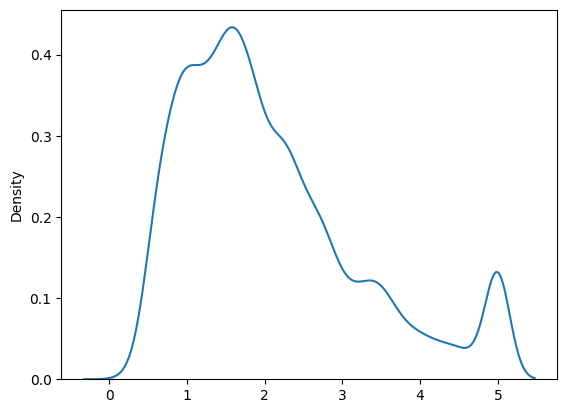

In [ ]:
# Diagnosing for excess kurtosis
sns.kdeplot(y)

The figure below illustrates that the **target** distribution exhibits **excess kurtosis** on the right side, suggesting the presence of heavy tails or extreme values.

We can formally assess this by applying the **kurtosis test**, which was previously implemented in the `diagnose_kurtosis` function. The null hypothesis for the test is that the sample follows a normal distribution with no excess kurtosis.

In [31]:
diagnose_kurtosis(y)

Excess Kurtosis: 0.33
Kurtosis Test p-value: 0.0000
Significant non-normal kurtosis detected (p < 0.05)


Given that the **p-value** is less than 0.05, we reject the assumption that the target variable follows a normal distribution. The presence of excess kurtosis suggests that the distribution is not normal, and it has heavy tails or extreme outliers that can affect model performance.


Since the normality assumption does not hold, we can apply a transformation to handle the excess kurtosis. One common approach is to use the **Box-Cox transformation**, which is known to stabilize variance and make the distribution more normal-like.


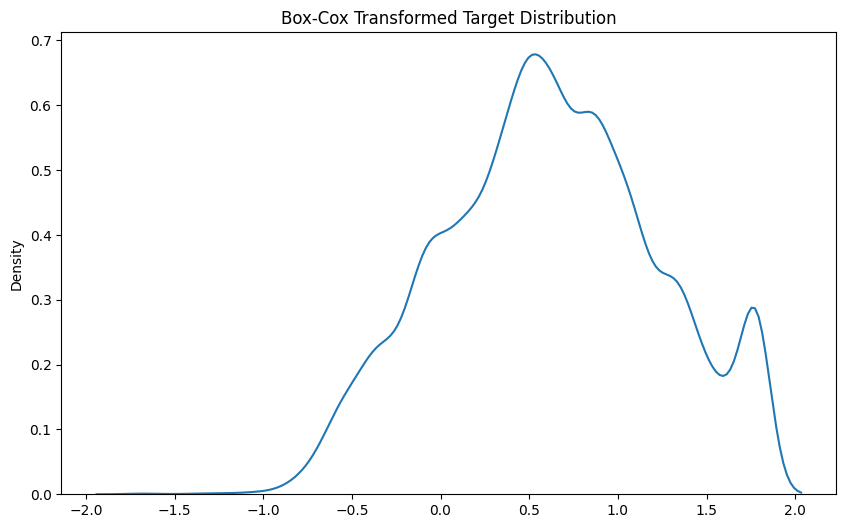

In [34]:
# Apply Box-Cox transformation
target_transformed, lambda_ = stats.boxcox(y)

# Check if transformation improves normality
plt.figure(figsize=(10, 6))
sns.kdeplot(target_transformed)
plt.title("Box-Cox Transformed Target Distribution")
plt.show()

In [35]:
diagnose_kurtosis(target_transformed)

Excess Kurtosis: -0.52
Kurtosis Test p-value: 0.0000
Significant non-normal kurtosis detected (p < 0.05)


The tranformed target also fails to normal kurtosis.

Lets run the simple linear regression on the target variable.

In [40]:
# Simple regression
X_sm = sm.add_constant(X['MedInc'])
model = sm.OLS(y, X_sm).fit()

 ### Diagram
 Residual plot to visualize heteroscedasticity:

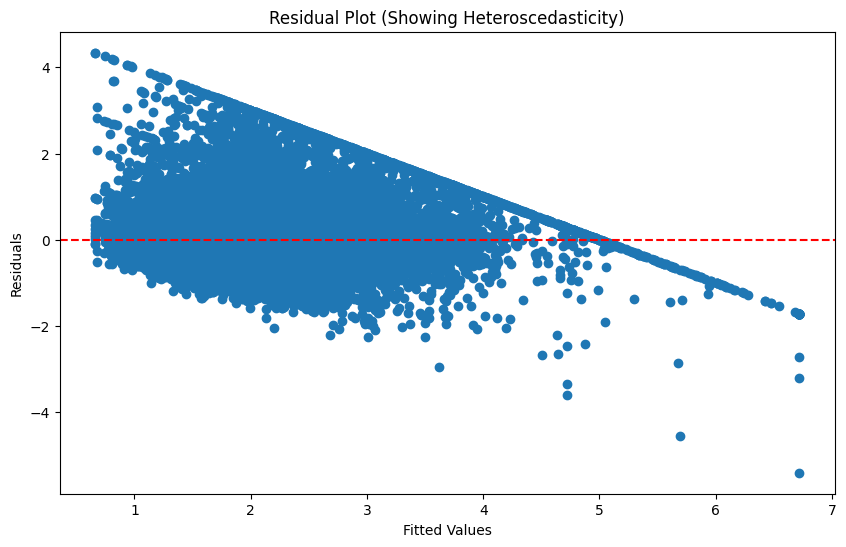

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Showing Heteroscedasticity)")
plt.show()

The residuals plot shows heteroscedasticity.

 ### Diagnosis

 We can test for heteroscedasticity by performing the Breush-Pagan Test
 Formal tests for heteroscedasticity:

In [42]:
def diagnose_heteroscedasticity(model):
    bp_test = het_breuschpagan(model.resid, model.model.exog)
    print(f"Breusch-Pagan Test p-value: {bp_test[1]:.4f}")
    if bp_test[1] < 0.05:
        print("Significant heteroscedasticity detected")
    else:
        print("No significant heteroscedasticity detected")

diagnose_heteroscedasticity(model)

Breusch-Pagan Test p-value: 0.0000
Significant heteroscedasticity detected


 ## References
 1. DeCarlo, L. T. (1997). "On the Meaning and Use of Kurtosis." *Psychological Methods*, **2**(3), 292–307.
 2. Breusch, T. S., & Pagan, A. R. (1979). "A Simple Test for Heteroscedasticity and Random Coefficient Variation." *Econometrica*, **47**(5), 1287–1294.
 3. Westfall, P. H., & Young, S. S. (1993). "Resampling-Based Multiple Testing: Examples and Methods for P-value Adjustment." *John Wiley & Sons*.
 4. Wooldridge, J. M. (2012). *Introductory Econometrics: A Modern Approach* (5th ed.). South-Western Cengage Learning. 
 

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


<Figure size 1000x500 with 0 Axes>

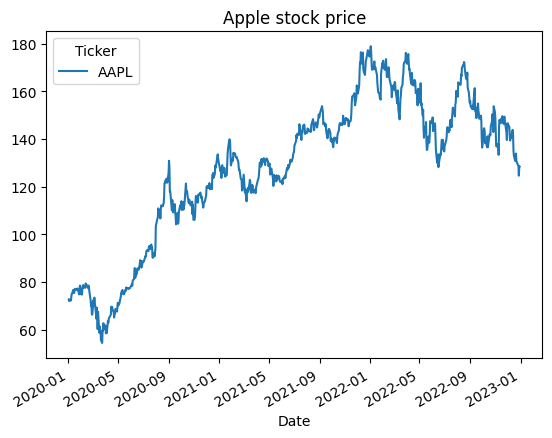

In [49]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss

# Generate a non-stationary time series (Random Walk)
aaple = yf.download("AAPL", start="2020-01-01", end="2023-01-01")["Close"]

# Plot the time series
plt.figure(figsize=(10, 5))
aaple.plot(title='Apple stock price')
plt.show()

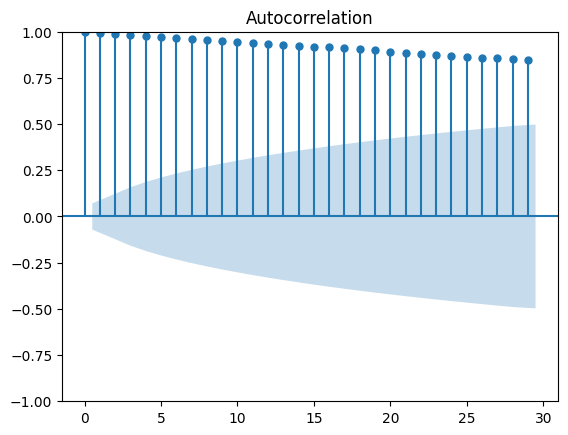

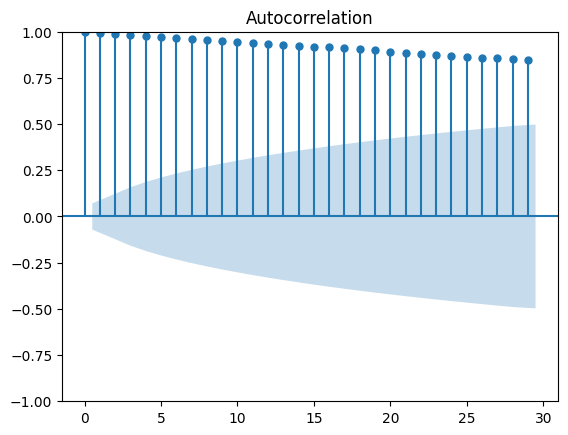

In [50]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(aaple)

ADF Statistic: -1.889
p-value: 0.337
The series is non-stationary (fail to reject H0)


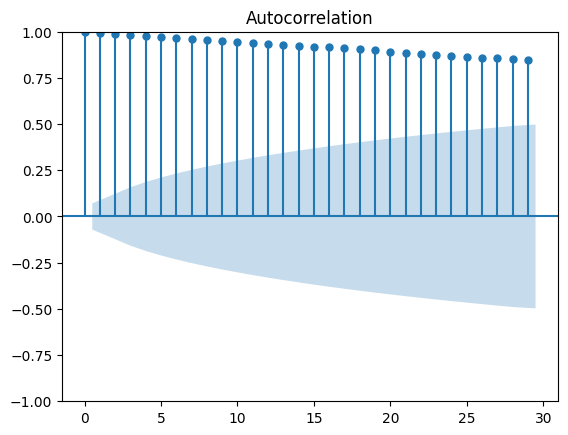

In [52]:
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")
    if result[1] < 0.05:
        print("The series is stationary (reject H0)")
    else:
        print("The series is non-stationary (fail to reject H0)")


plot_acf(aaple)
adf_test(aaple)

<Figure size 1000x500 with 0 Axes>

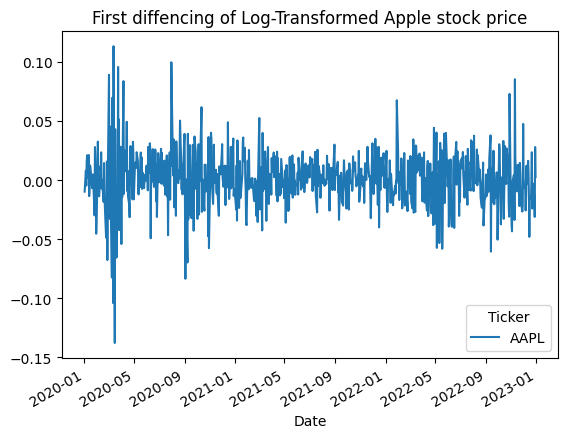

ADF Statistic: -8.749
p-value: 0.000
The series is stationary (reject H0)


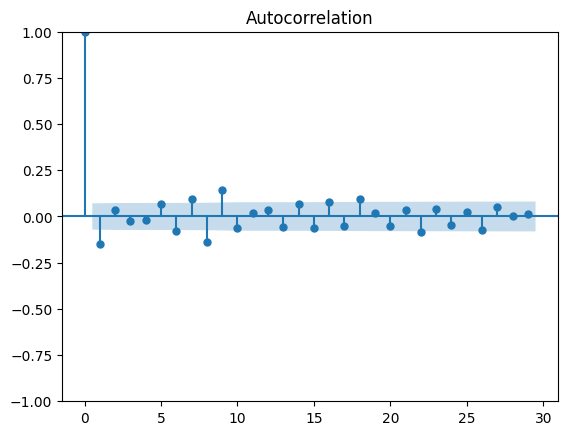

In [53]:

log_aaple = np.log(aaple) # Log transformation of Apple stock price
log_aaple_diff = log_aaple.diff().dropna() # First differencing

plt.figure(figsize=(10, 5))
log_aaple_diff.plot(title='First diffencing of Log-Transformed Apple stock price')
plt.show()

plot_acf(log_aaple_diff)
adf_test(log_aaple_diff)

